## Load pre-trained EPiC-FM models

In [2]:
from DynGenModels.configs.registered_experiments import Config_JetClass_EPiC_CondFlowMatch
from DynGenModels.models.experiment import Experiment
from DynGenModels.datamodules.jetclass.dataprocess import PostProcessJetClassData as Postprocessor
from DynGenModels.datamodules.jetclass.dataprocess import PreProcessJetClassData as Preprocessor

from utils import plot_consitutents, plot_jets 

- time emebdding: Gaussian
- dim_time_emebed = 12

+----------------------+---------------------+
| Parameters           | Values              |
+----------------------+---------------------+
| NAME                 | qcd_to_top          |
| DATASET              | jetclass            |
| DATA_SOURCE          | qcd                 |
| DATA_TARGET          | top                 |
| MAX_NUM_CONSTITUENTS | 30                  |
| FEATURES             | constituents        |
| PREPROCESS           | ['standardize']     |
| DIM_INPUT            | 3                   |
| DEVICE               | cuda:1              |
| OPTIMIZER            | Adam                |
| LR                   | 0.0001              |
| WEIGHT_DECAY         | 0.0                 |
| OPTIMIZER_BETAS      | [0.9, 0.999]        |
| OPTIMIZER_EPS        | 1e-08               |
| OPTIMIZER_AMSGRAD    | False               |
| GRADIENT_CLIP        | 1.0                 |
| SCHEDULER            |                     |
| SCHEDULER_T_MAX      |                     |
| SCHEDULER_E

  0%|          | 0/98 [00:00<?, ?it/s]

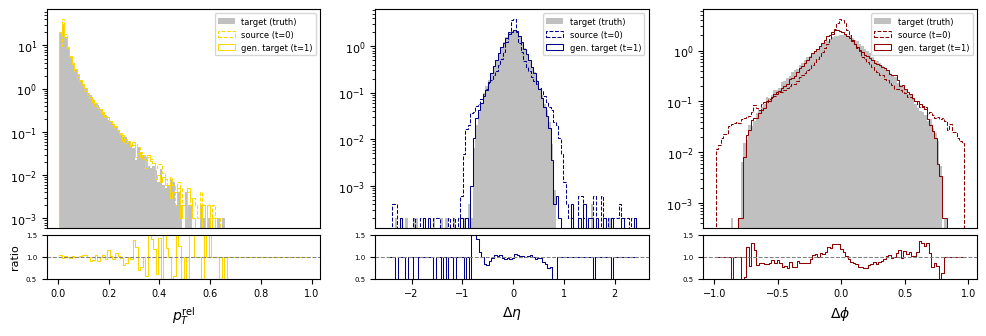

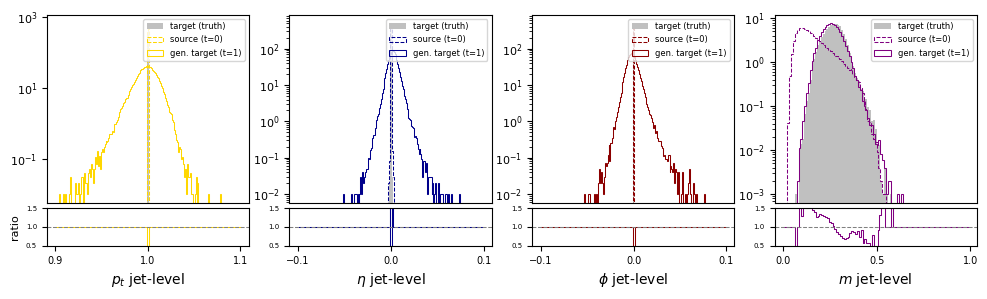

In [4]:
from  DynGenModels.models.experiment import Experiment

path = '../../results/qcd_to_top.OptimalTransportCFM.EPiC.2024.03.08_12h23'

cfm = Experiment(Config_JetClass_EPiC_CondFlowMatch, path=path, DEVICE='cuda:0', NUM_SAMPLING_STEPS=300)
cfm.load(model='best')
cfm.generate_samples(cfm.dataset.source_preprocess, Postprocessor=Postprocessor)
plot_consitutents(cfm, save_dir=path, features=[r'$p^{\rm rel}_T$', r'$\Delta\eta$', r'$\Delta\phi$'], figsize=(12,3.5))
plot_jets(cfm, save_dir=path, features=[r'$p_t$', r'$\eta$', r'$\phi$', r'$m$'], figsize=(12,3))

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import matplotlib.gridspec as gridspec

def coord_transform(features, output_coords='pt_eta_phi_m'):

    if output_coords == 'pt_eta_phi_m':
        px, py, pz, e = features[...,0], features[...,1], features[...,2], features[...,3]
        pt = torch.sqrt(px**2 + py**2)
        eta = 0.5 * torch.log( (e + pz) / (e - pz))
        phi = torch.arctan2(py, px)
        m = torch.sqrt(e**2 - px**2 - py**2 - pz**2)
        return torch.stack([pt, eta, phi, m], dim=1)

    elif output_coords == 'px_py_pz_e':
        pt, eta, phi, m = features[...,0], features[...,1], features[...,2], features[...,3]
        mt = torch.sqrt(m**2 + pt**2)
        px, py, pz = pt * torch.cos(phi), pt * torch.sin(phi), mt * torch.sinh(eta)
        e = torch.sqrt(m**2 + px**2 + py**2 + pz**2)    
        return torch.stack([px, py, pz, e], dim=1)


def get_feats_constiutuents(massless_constituents):
    if massless_constituents.shape[-1] == 3:
        x = massless_constituents.reshape(-1,3)
        x = torch.cat([x, torch.zeros_like(x)[..., None, 0]], dim=-1) # add zero masses
    elif massless_constituents.shape[-1] == 4:
        x = massless_constituents
    else:
        raise ValueError('Invalid shape for massless_constituents')
    x = coord_transform(x, output_coords='px_py_pz_e').reshape(-1, massless_constituents.shape[1],4).sum(-2) # sum over particles four-momenta
    return coord_transform(x, output_coords='pt_eta_phi_m') # convert to pt, eta, phi, m


def plot_consitutents(trained_model, 
                    save_dir=None, 
                    plot_source=True,
                    features=[r'$p^{\rm rel}_T$', r'$\Delta\eta$', r'$\Delta\phi$'], 
                    bins=[np.arange(0,1,0.01), np.arange(-2.5, 2.5, 0.05), np.arange(-1, 1, 0.02)], 
                    color = ['gold', 'darkblue', 'darkred'],
                    num_particles=100000, 
                    figsize=(10, 3)):
    
    if plot_source: jet0 = trained_model.pipeline.trajectories[0].reshape(-1,3).detach().cpu().numpy()
    jet1 = trained_model.pipeline.trajectories[-1].reshape(-1,3).detach().cpu().numpy()
    jet_true = trained_model.dataset.target[:jet1.shape[0]].detach().cpu().numpy()
    
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, len(features), height_ratios=[5, 1])
    gs.update(hspace=0.05)
    
    for idx, feature in enumerate(features):
        ax = fig.add_subplot(gs[idx])
        h, b, _ = ax.hist(jet_true[..., idx].flatten()[:num_particles], bins=bins[idx], log=True , color='silver', density=True, label='target (truth)')
        if plot_source: _, _, _ = ax.hist(jet0[..., idx].flatten()[:num_particles], bins=bins[idx], log=True, color=color[idx], ls='--', histtype='step', density=True, lw=0.75, label='source (t=0)')
        h1, _, _ = ax.hist(jet1[..., idx].flatten()[:num_particles], bins=bins[idx], log=True, color=color[idx], histtype='step', density=True, lw=0.75 , label='gen. target (t=1)')
        ax.set_xticklabels([])
        ax.set_xticks([])
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(8)
        ax.legend(fontsize=6, loc='upper right')

        #...ratio plot
        ax_ratio = fig.add_subplot(gs[idx + 3])
        ratio = np.divide(h1, h, out=np.ones_like(h), where=h != 0)
        ax_ratio.plot(0.5 * (b[:-1] + b[1:]), ratio,  drawstyle='steps-post', color=color[idx],lw=0.75)
        ax_ratio.set_ylim(0.5, 1.5, 0) # Adjust this as needed
        ax_ratio.set_xlabel(feature)
        ax_ratio.axhline(1, color='gray', linestyle='--', lw=0.75)
        for tick in ax_ratio.xaxis.get_major_ticks():
            tick.label.set_fontsize(7)
        for tick in ax_ratio.yaxis.get_major_ticks():
            tick.label.set_fontsize(5)  
        if idx == 0:
            ax_ratio.set_ylabel('ratio', fontsize=8)
        ax_ratio.set_yticks([0.5, 1, 1.5])
    if save_dir is not None:
        plt.savefig(save_dir + '/particle_features.pdf')
    else:
        plt.show()
        

def plot_jets(trained_model, 
              save_dir=None,
              figsize=(12, 2),
              plot_source=True,
              features=[r'$p_t$', r'$\eta$', r'$\phi$', r'$m$'],
              color = ['gold', 'darkblue', 'darkred', 'purple'],
              bins = [np.arange(0.9,1.1,0.001), 
                        np.arange(-0.1,0.1,0.001), 
                        np.arange(-0.1,0.1,0.001), 
                        np.arange(0.,1,0.01)
                        ]):

    if plot_source: jet0 = get_feats_constiutuents(trained_model.dataset.source)
    jet1 = get_feats_constiutuents(trained_model.pipeline.trajectories[-1])
    jet_target = get_feats_constiutuents(trained_model.dataset.target)

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, len(features), height_ratios=[5, 1])
    gs.update(hspace=0.05) 
    
    for i in range(len(features)):
        ax = fig.add_subplot(gs[i])
        h, b, _ = ax.hist(jet_target[...,i], bins=bins[i], log=True, color='silver', histtype='stepfilled', density=True, lw=0.75, label='target (truth)')
        if plot_source: ax.hist(jet0[...,i], bins=bins[i], log=True, color=color[i], histtype='step', ls='--', density=True, lw=0.75, label='source (t=0)')
        h1, _, _ = ax.hist(jet1[...,i], bins=bins[i], log=True, color=['gold', 'darkblue', 'darkred', 'purple'][i], histtype='step', density=True, lw=0.75, label='gen. target (t=1)')

        ax.set_xticklabels([])
        ax.set_xticks([])
        for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(8)
        ax.legend(fontsize=6, loc='upper right')
        
        # Ratio plot:
        ax_ratio = fig.add_subplot(gs[i + 4])
        ratio = np.divide(h1, h, out=np.ones_like(h), where=h != 0)
        ax_ratio.plot(0.5 * (b[:-1] + b[1:]), ratio, drawstyle='steps-post', color=color[i],lw=0.75)
        ax_ratio.set_ylim(0.5, 1.5, 0) # Adjust this as needed
        ax_ratio.set_xlabel(features[i] + ' jet-level')
        ax_ratio.axhline(1, color='gray', linestyle='--', lw=0.75)
        for tick in ax_ratio.xaxis.get_major_ticks(): tick.label.set_fontsize(7)
        for tick in ax_ratio.yaxis.get_major_ticks(): tick.label.set_fontsize(5)  
        if i == 0: ax_ratio.set_ylabel('ratio', fontsize=8)
        ax_ratio.set_yticks([0.5, 1, 1.5])

    if save_dir is not None:
        plt.savefig(save_dir + '/jet_features.pdf')
    else:
        plt.show()

/tmp/ipykernel_3011269/3598632112.py:61: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(8)
/tmp/ipykernel_3011269/3598632112.py:68: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax_ratio.set_ylim(0.5, 1.5, 0) # Adjust this as needed
/tmp/ipykernel_3011269/3598632112.py:72: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(7)
/tmp/ipykernel_3011269/3598632112.py:74: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(5)
/tmp/ipykernel_3011269/3598632112.py:112: MatplotlibDeprecationWarning: The label function was depreca

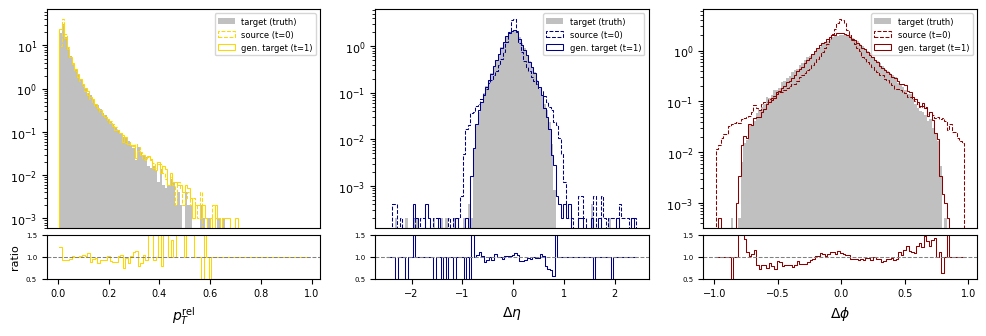

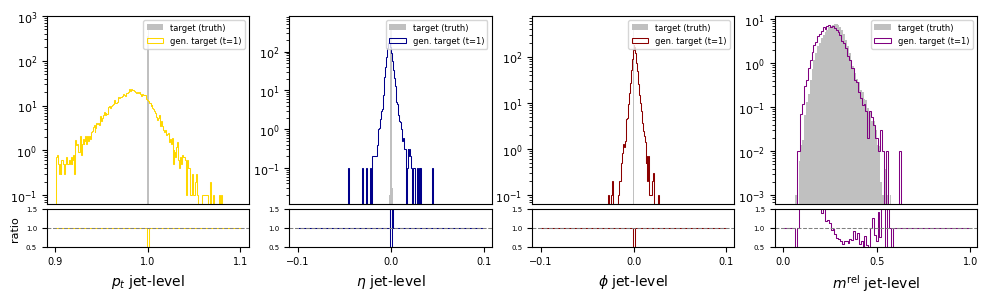

In [82]:
plot_consitutents(cfm_1, save_dir=path, features=[r'$p^{\rm rel}_T$', r'$\Delta\eta$', r'$\Delta\phi$'], figsize=(12,3.5))
plot_jets(cfm_1, save_dir=path, plot_source=False, features=[r'$p_t$', r'$\eta$', r'$\phi$', r'$m^{\rm rel}$'], figsize=(12,3))

+----------------------+-----------------+
| Parameters           | Values          |
+----------------------+-----------------+
| NAME                 | qcd_to_top      |
| DATASET              | jetclass        |
| DATA_SOURCE          | qcd             |
| DATA_TARGET          | top             |
| MAX_NUM_CONSTITUENTS | 30              |
| FEATURES             | constituents    |
| PREPROCESS           | ['standardize'] |
| DIM_INPUT            | 3               |
| DEVICE               | cuda:2          |
| OPTIMIZER            | Adam            |
| LR                   | 0.0001          |
| WEIGHT_DECAY         | 0.0             |
| OPTIMIZER_BETAS      | [0.9, 0.999]    |
| OPTIMIZER_EPS        | 1e-08           |
| OPTIMIZER_AMSGRAD    | False           |
| GRADIENT_CLIP        | 1.0             |
| SCHEDULER            |                 |
| SCHEDULER_T_MAX      |                 |
| SCHEDULER_ETA_MIN    |                 |
| SCHEDULER_GAMMA      |                 |
| SCHEDULER

  0%|          | 0/10 [00:00<?, ?it/s]

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


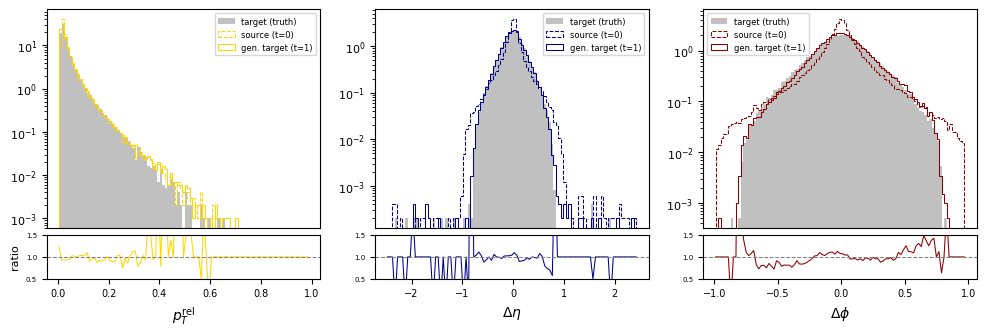

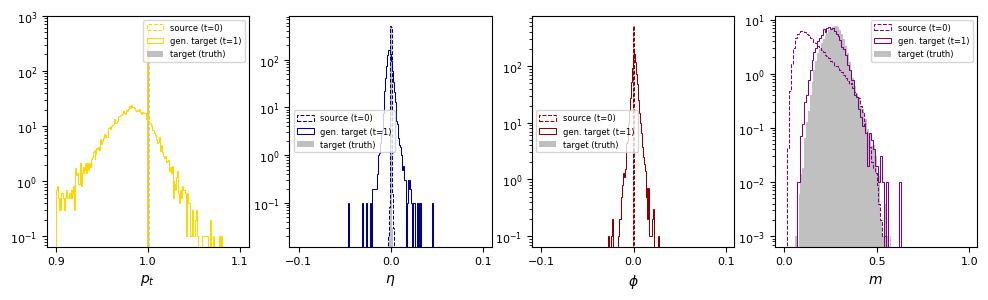

In [7]:
path = '../../results/qcd_to_top.CFM.EPiC.2024.02.22_18h17'
cfm_1 = Experiment(Config_JetClass_EPiC_CondFlowMatch, path=path, DEVICE='cuda:1', )
cfm_1.load(model='best')
cfm_1.generate_samples(cfm_1.dataset.source_preprocess[:10000], Postprocessor=Postprocessor)
plot_consitutents(cfm_1, save_dir=path, features=[r'$p^{\rm rel}_T$', r'$\Delta\eta$', r'$\Delta\phi$'], figsize=(12,3.5))
plot_jets(cfm_1, save_dir=path, features=[r'$p_t$', r'$\eta$', r'$\phi$', r'$m$'], figsize=(12,3))